In [12]:
import os
import subprocess
import xml.etree.ElementTree as ET
from pathlib import Path

# ------------------------
# Config — edit these
# ------------------------
inkscape_file = r"D:\PhD\figures\paper\BT_S2.svg"
full_res_folder = r"D:\PhD\figures\paper\full_pdfs"   # put ct_tree_branches.pdf here
output_pdf = r"D:\PhD\figures\paper\final_layout.pdf"
temp_svg = r"D:\PhD\figures\paper\temp_layout.svg"

# Placeholder → filename mapping (PDF filenames)
replacement_map = {
    "figure_1-1": "ct_tree_branches.pdf",
    # add more mappings: "placeholder_id": "file.pdf"
}

# ------------------------
# Namespaces
# ------------------------
SVG_NS = "http://www.w3.org/2000/svg"
XLINK_NS = "http://www.w3.org/1999/xlink"
ET.register_namespace("", SVG_NS)
ET.register_namespace("xlink", XLINK_NS)

# ------------------------
# Helpers
# ------------------------
def file_uri(path):
    """Return file:/// URL for a local path (works on Windows & Unix)."""
    p = Path(path).absolute()
    return "file:///" + str(p).replace("\\", "/")

def find_by_id(root, elem_id):
    for elem in root.iter():
        if elem.get("id") == elem_id:
            return elem
    return None

def build_parent_map(root):
    return {child: parent for parent in root.iter() for child in parent}

# ------------------------
# Load SVG
# ------------------------
tree = ET.parse(inkscape_file)
root = tree.getroot()
parent_map = build_parent_map(root)

replacements_done = 0

for placeholder_id, filename in replacement_map.items():

    placeholder = find_by_id(root, placeholder_id)
    if placeholder is None:
        print(f"[WARN] ID '{placeholder_id}' not found.")
        continue

    pdf_path = os.path.join(full_res_folder, filename)
    if not os.path.exists(pdf_path):
        print(f"[WARN] PDF not found: {pdf_path}")
        continue

    parent = parent_map.get(placeholder, root)
    # index to keep same stacking order
    try:
        index = list(parent).index(placeholder)
    except ValueError:
        index = None

    # preserve transform and any explicit position attributes if present
    transform = placeholder.get("transform")
    x = placeholder.get("x")
    y = placeholder.get("y")
    width = placeholder.get("width")
    height = placeholder.get("height")

    # create image element that links to the PDF
    image_elem = ET.Element(f"{{{SVG_NS}}}image")
    image_elem.set("id", placeholder_id)
    image_elem.set(f"{{{XLINK_NS}}}href", file_uri(pdf_path))

    # preserve transform or explicit geometry if available
    if transform:
        image_elem.set("transform", transform)
    if x is not None:
        image_elem.set("x", x)
    if y is not None:
        image_elem.set("y", y)
    if width is not None:
        image_elem.set("width", width)
    if height is not None:
        image_elem.set("height", height)

    # replace in tree
    parent.remove(placeholder)
    if index is None:
        parent.append(image_elem)
    else:
        parent.insert(index, image_elem)

    replacements_done += 1
    print(f"Replaced '{placeholder_id}' → {pdf_path}")

# ------------------------
# Save temporary SVG
# ------------------------
tree.write(temp_svg, encoding="utf-8", xml_declaration=True)
print(f"Saved temp SVG: {temp_svg} (replacements: {replacements_done})")

# ------------------------
# Export to PDF using Inkscape
# ------------------------
inkscape_cmd = [
    "inkscape",
    temp_svg,
    "--export-type=pdf",
    "--export-filename", output_pdf
]

print("Calling Inkscape to export final PDF...")
proc = subprocess.run(inkscape_cmd, capture_output=True, text=True)
print("Inkscape returncode:", proc.returncode)
if proc.stdout:
    print("stdout:", proc.stdout)
if proc.stderr:
    print("stderr:", proc.stderr)

if proc.returncode == 0:
    print("Final PDF exported:", output_pdf)
else:
    print("Export failed. Check stderr above.")

Replaced 'figure_1-1' → D:\PhD\figures\paper\full_pdfs\ct_tree_branches.pdf
Saved temp SVG: D:\PhD\figures\paper\temp_layout.svg (replacements: 1)
Calling Inkscape to export final PDF...
Inkscape returncode: 0
stderr: Pixbuf::create_from_file: Unrecognized image file format
   (D:\PhD\figures\paper\full_pdfs\ct_tree_branches.pdf)
Pixbuf::create_from_file: Unrecognized image file format
   (D:\PhD\figures\paper\full_pdfs\ct_tree_branches.pdf)
** Message: 23:54:40.922: Invalid glyph found, continuing...

Final PDF exported: D:\PhD\figures\paper\final_layout.pdf


In [21]:
import numpy as np

times = np.loadtxt(r"D:\PhD\SCITERNA\simulated_data\5000c100m\sciterna\sciterna_runtimes.txt")
np.mean(times)

3340.1949

In [20]:
times = np.loadtxt(r"D:\PhD\SCITERNA\simulated_data\5000c100m\dendro\dendro_runtimes.txt")
np.mean(times)

346.02061061786884

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import nbinom
import pandas as pd
import seaborn as sns
import dendropy
from dendropy.calculate import treecompare
from src_python.cell_tree import CellTree

In [24]:
def to_newick(ct, node):
    if ct.isleaf(node):
        return f"{node}"
    children = ct.children(node)
    return "(" + ",".join(to_newick(ct, child) for child in children) + f"){node}"

In [55]:
true_parent_vec = np.loadtxt(r"D:\PhD\SCITERNA\simulated_data\50c500m5\parent_vec\parent_vec_0.txt", dtype=int)
rf_distances = []
n_bootstrap = 1000
n_c = 50

for i in range(n_bootstrap):
    parent_vec = np.loadtxt(rf"D:\PhD\SCITERNA\simulated_data\50c500m5\sciterna_bootstrapping\sciterna_parent_vec\sciterna_parent_vec_1r{i}.txt", dtype=int)

    ct_gt = CellTree(n_c)
    ct_dendro = CellTree(n_c)

    ct_gt.use_parent_vec(true_parent_vec)
    ct_dendro.use_parent_vec(parent_vec)

    newick1 = to_newick(ct_gt, ct_gt.main_root) + ";"
    newick2 = to_newick(ct_dendro, ct_dendro.main_root) + ";"
    taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])
    tree1 = dendropy.Tree.get(data=newick1, schema="newick", taxon_namespace=taxa)
    tree2 = dendropy.Tree.get(data=newick2, schema="newick", taxon_namespace=taxa)

    rf_distances.append(treecompare.unweighted_robinson_foulds_distance(tree1, tree2))

FileNotFoundError: D:\PhD\SCITERNA\simulated_data\50c500m5\sciterna_bootstrapping\sciterna_parent_vec\sciterna_parent_vec_1r573.txt not found.

In [56]:
from collections import Counter

n_c = 50
taxa = dendropy.TaxonNamespace([str(i) for i in range(n_c)])

# counter for all splits across all bootstrap trees
split_counts = Counter()

for i in range(n_bootstrap):
    parent_vec = np.loadtxt(
        rf"D:\PhD\SCITERNA\simulated_data\50c500m5\sciterna_bootstrapping\sciterna_parent_vec\sciterna_parent_vec_1r{i}.txt",
        dtype=int
    )

    ct = CellTree(n_c)
    ct.use_parent_vec(parent_vec)
    newick = to_newick(ct, ct.main_root) + ";"

    tree = dendropy.Tree.get(data=newick, schema="newick", taxon_namespace=taxa)
    tree.encode_bipartitions()

    # record each split (bipartition)
    for bp in tree.bipartition_encoding:
        split_counts[bp] += 1

FileNotFoundError: D:\PhD\SCITERNA\simulated_data\50c500m5\sciterna_bootstrapping\sciterna_parent_vec\sciterna_parent_vec_1r573.txt not found.

In [57]:
# Sort splits by how frequently they appear
sorted_splits = sorted(split_counts.items(), key=lambda x: x[1], reverse=True)

counts = []
large_support = []
for bp, count in sorted_splits[:]:

    counts.append(count)
    if count > 500:
        large_support.append(count)

In [58]:
len(large_support)

54

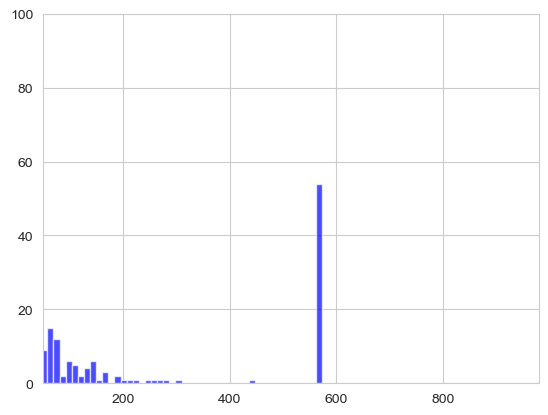

In [59]:
plt.hist(counts, bins=50, density=False, alpha=0.7, color='blue')
plt.xlim(50,980)
plt.ylim(0,100)
plt.show()

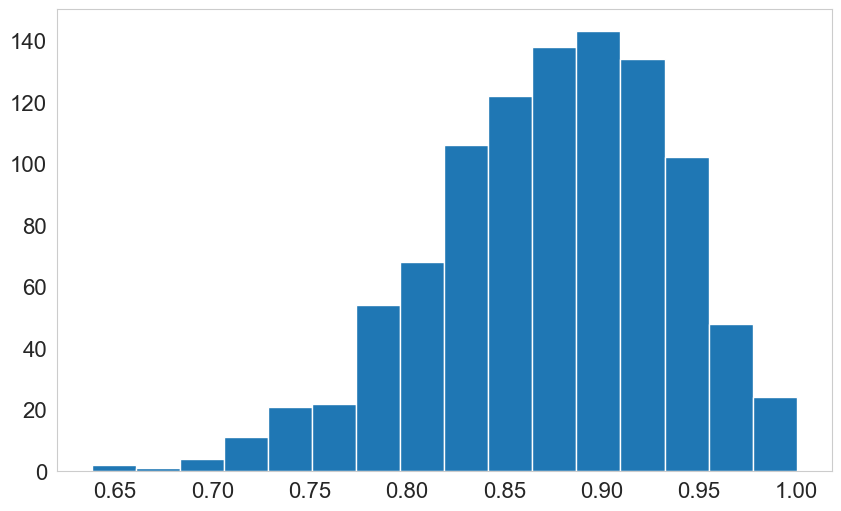

In [36]:
plt.figure(figsize=(10,6))
plt.hist(np.array(rf_distances)/94, bins=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

In [70]:
mu, alpha, pi = 60, 5.88, 0.39 # alpha: dispersion, pi: zero-inflation probability
n = 1 / alpha  # number of successes
p = 1 / (1 + alpha * mu)
nb_samples = nbinom.rvs(n, p, size=(100,100))
zero_inflation_mask = np.random.rand(100,100) < pi
coverage = np.where(zero_inflation_mask, 0, nb_samples)

print(np.mean(coverage == 0))
print(np.mean(coverage))

0.6143
33.347


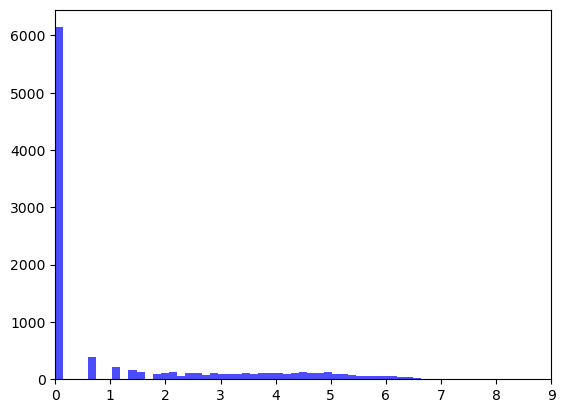

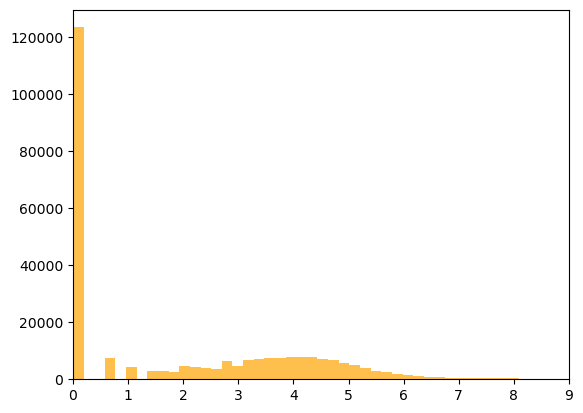

In [88]:
plt.hist(np.log(coverage.flatten()+1), bins=50, density=False, alpha=0.7, color='blue')
plt.xlim(0,9)
plt.show()


alt = pd.read_csv(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\mm34\alt.csv", header=None)
ref = pd.read_csv(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\mm34\ref.csv", header=None)
cov = np.array(alt.iloc[1:,1:]).astype(int) + np.array(ref.iloc[1:,1:]).astype(int)

plt.hist(np.log(cov.flatten()+1), bins=50, density=False, alpha=0.7, color='orange')
plt.xlim(0,9)
plt.show()

In [102]:
path = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\mm34\phylinsic\phylinsic_genotype\phylinsic_genotype.txt"

# Use a single space as delimiter and the python engine so consecutive spaces are not collapsed.
df = pd.read_csv(path, sep=' ', header=None, engine='python', dtype=str)

# Replace cells that are '' or only whitespace with actual NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# If you need a numpy array:
genotype_pred = df.values[1:]

print(genotype_pred)

[['A' 'A' 'A' ... nan 'A' nan]
 ['R' 'R' 'R' ... 'R' 'R' nan]
 ['R' 'R' 'R' ... 'R' 'R' nan]
 ...
 [nan nan nan ... 'A' 'A' 'A']
 [nan nan nan ... 'A' 'A' 'A']
 ['A' nan nan ... 'A' 'A' nan]]


In [104]:
alt = np.loadtxt(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\mm34\alt.txt")
ref = np.loadtxt(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\mm34\ref.txt")
cov = alt + ref

# genotype_pred = np.loadtxt(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\mm34\phylinsic\phylinsic_genotype\phylinsic_genotype.txt", dtype=str)
# genotype_pred = np.loadtxt(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\mm34\sciterna\sciterna_genotype\sciterna_genotype_1r0.txt", dtype=str)

mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0, np.nan : np.nan}
vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
genotype_predicted = vectorized_map(genotype_pred)

In [43]:
alt = np.loadtxt(r"D:\PhD\SCITERNA\simulated_data\50c500m\alt\alt_0.txt")
ref = np.loadtxt(r"D:\PhD\SCITERNA\simulated_data\50c500m\ref\ref_0.txt")
cov = alt + ref
genotype_pred = np.loadtxt(r"D:\PhD\SCITERNA\simulated_data\50c500m\phylinsic\phylinsic_genotype\phylinsic_genotype_0.txt", dtype=str)[1:]

mapping_dict = {'A': 1.0, 'H': 0.5, 'R': 0}
vectorized_map = np.vectorize(lambda x: float(mapping_dict[x]))
genotype_predicted = vectorized_map(genotype_pred)

C:\Users\Norio\AppData\Local\Temp\ipykernel_25124\520276231.py:1: RuntimeWarning: invalid value encountered in divide
  sns.heatmap((alt/cov), cmap='viridis')


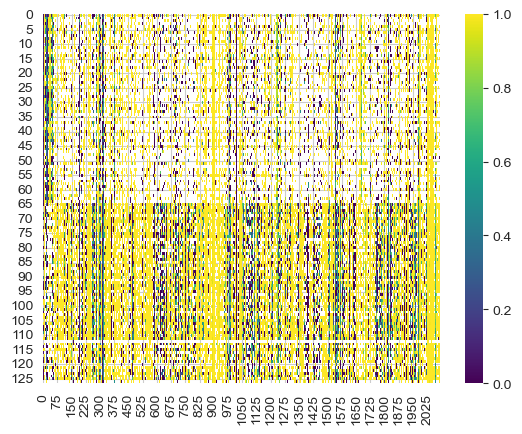

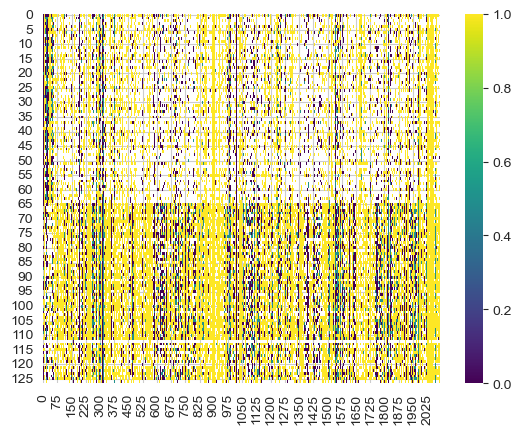

C:\Users\Norio\AppData\Local\Temp\ipykernel_25124\520276231.py:8: RuntimeWarning: invalid value encountered in divide
  sns.heatmap(np.vstack([(alt/cov)[:2,:100], genotype_predicted.T[:2, :100]]), cmap='viridis')


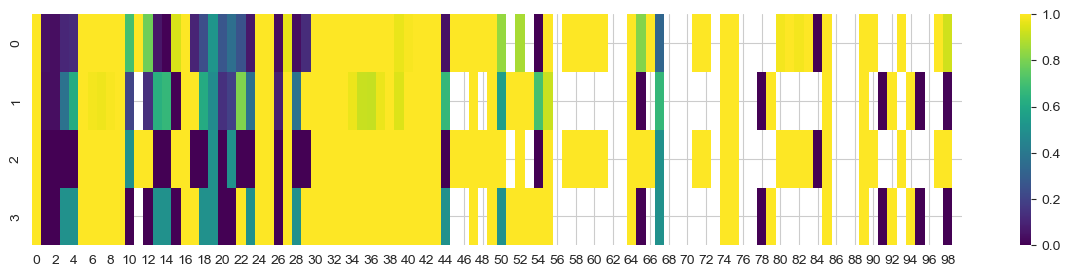

In [107]:
sns.heatmap((alt/cov), cmap='viridis')
plt.show()

sns.heatmap(genotype_predicted.T, cmap='viridis')
plt.show()

plt.figure(figsize=(15, 3))
sns.heatmap(np.vstack([(alt/cov)[:2,:100], genotype_predicted.T[:2, :100]]), cmap='viridis')
plt.show()

In [72]:
path = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\mm34\phylinsic\output\phylogeny\mutations.fa"

sequences = {}
with open(path, 'r') as f:
    header = None
    seq_lines = []
    for line in f:
        line = line.strip()
        if not line:
            continue
        if line.startswith('>'):
            if header:
                sequences[header] = ''.join(seq_lines)
            header = line[1:]  # remove '>'
            seq_lines = []
        else:
            seq_lines.append(line)
    if header:
        sequences[header] = ''.join(seq_lines)

# --- Convert to NumPy array ---
names = list(sequences.keys())
seqs = list(sequences.values())

# Find the longest sequence length
max_len = max(len(seq) for seq in seqs)

# Pad shorter sequences with NaN or '-'
char_matrix = np.full((len(seqs), max_len), np.nan, dtype=object)

for i, seq in enumerate(seqs):
    char_matrix[i, :len(seq)] = list(seq)

In [81]:
# for c in range(500):
#     print(np.unique(char_matrix[:,c]))

In [74]:
genotype_pred

array([['A', 'A', 'A', ..., nan, 'A', nan],
       ['R', 'R', 'R', ..., 'R', 'R', nan],
       ['R', 'R', 'R', ..., 'R', 'R', nan],
       ...,
       [nan, nan, nan, ..., 'A', 'A', 'A'],
       [nan, nan, nan, ..., 'A', 'A', 'A'],
       ['A', nan, nan, ..., 'A', 'A', nan]], dtype=object)

In [99]:
ref = pd.read_csv(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\input_data\mm34\ref.csv")

In [101]:
import numpy as np
import pandas as pd
from pathlib import Path
from textwrap import wrap

# --- Inputs already in your session ---
# ref: pandas DataFrame
#   - ref.columns[1:] are locus identifiers like 'GL000251.2:1423687:C:T' (one per locus, in order)
#   - ref["Cell"] contains cell names (in order)
# genotype_pred: numpy array of shape (n_loci, n_cells)
#   - rows = loci (same order as ref.columns[1:])
#   - cols = cells (same order as ref["Cell"])

# --- Safety checks (will raise helpful errors if shapes/mismatch) ---
n_cells, n_loci = genotype_pred.shape
loci_from_ref = list(ref.columns[1:])            # length should be n_loci
cells_from_ref = list(ref["Cell"].astype(str))   # length should be n_cells

if len(loci_from_ref) != n_loci:
    raise ValueError(f"Number of loci mismatch: genotype_pred has {n_loci} loci but ref.columns[1:] has {len(loci_from_ref)}")

if len(cells_from_ref) != n_cells:
    raise ValueError(f"Number of cells mismatch: genotype_pred has {n_cells} cells but ref['Cell'] has {len(cells_from_ref)}")

# --- iupac map for two-base sets -> ambiguity code ---
pair_to_iupac = {
    frozenset(['A','G']): 'R',
    frozenset(['C','T']): 'Y',
    frozenset(['G','T']): 'K',
    frozenset(['A','C']): 'M',
    frozenset(['C','G']): 'S',
    frozenset(['A','T']): 'W'
}

# Helper to sanitize base char (upper and convert U->T)
def clean_base(b):
    if pd.isna(b):
        return None
    b = str(b).upper()
    if b == 'U':
        b = 'T'
    return b if b in ('A','C','G','T') else None

# --- Extract REF/ALT from locus identifiers ---
locus_refalt = []  # list of (ref_base, alt_base) for each locus in order
for locus in loci_from_ref:
    # Expected format: chrom:pos:REF:ALT (e.g. 'GL000251.2:1423687:C:T')
    parts = str(locus).split(':')
    if len(parts) >= 4:
        ref_allele = clean_base(parts[-2])
        alt_allele = clean_base(parts[-1])
    else:
        # fallback: try to find single-letter bases in the string (last two single-letter tokens)
        ref_allele, alt_allele = None, None

    if ref_allele is None or alt_allele is None:
        raise ValueError(f"Cannot parse REF/ALT from locus '{locus}'. Expected 'chr:pos:REF:ALT' format with bases A/C/G/T or U.")
    locus_refalt.append((ref_allele, alt_allele))

# --- Build sequences: rows = loci, cols = cells; produce one sequence per cell ---
cell_seqs = [''] * n_cells

for i in range(n_loci):
    ref_base, alt_base = locus_refalt[i]
    for j in range(n_cells):
        val = genotype_pred[j, i]  # expected to be strings like 'A', 'R', 'H', 'None' or np.nan
        # handle pandas/np missing
        if val is None or (isinstance(val, float) and np.isnan(val)) or str(val).strip().upper() in ('NONE', ''):
            base = 'N'
        else:
            code = str(val).strip().upper()
            if code == 'A':
                base = alt_base
            elif code == 'R':
                base = ref_base
            elif code == 'H':
                s = frozenset([ref_base, alt_base])
                base = pair_to_iupac.get(s)
            else:
                base = 'N'
        cell_seqs[j] += base

adjusted_cell_names = []
for name in cells_from_ref:
    digits = ''.join(ch for ch in name if ch.isdigit())
    if digits:
        suffix = '_0' if int(digits) <= 6710366 else '_1'
    else:
        suffix = ''
    adjusted_cell_names.append(f"{name}{suffix}")

# --- Build FASTA content with adjusted names ---
fasta_lines = []
for name, seq in zip(adjusted_cell_names, cell_seqs):
    fasta_lines.append(f">{name}")
    fasta_lines.extend(wrap(seq, 80))

fasta_content = "\n".join(fasta_lines) + "\n"

# --- Write to file (change path as needed) ---
outpath = Path(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\mm34\phylinsic\output\phylogeny\easy.fa")
outpath.parent.mkdir(parents=True, exist_ok=True)
outpath.write_text(fasta_content)

print(f"Wrote FASTA to: {outpath}")
print("Preview:")
print(fasta_content)

Wrote FASTA to: C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\mm34\phylinsic\output\phylogeny\easy.fa
Preview:
>SRR6710302_0
TTAYKTAGCCYGYSGRTYYSYRYRGAGGSSCGAGCCGAGAAAGAMCCACASRSYRRRKYCCSRYAYCSYYTCGCSAKRAA
AGAGMTCTAACRAAAYYCYYRRGCGAARTRACRRRRTTCGTGYYMTRRCRYRGRTRCACTCTTCCAGRRKRASACSTGRG
YGCATCCCGRCCGGTRWKTMWMSCCYCRRACKMGSGAGAAGRGYGTYAGCKMTATYGTGGYAGGYYTCRYRTRRCGCRAY
GAAGRGACRGGAGYRATTTACYAYTGYAMKYRTRRGGRACTGYCTACAKTKRATGSYYRYRRTSRATRGGTGYSYRRRSY
GCCYRRCTTYAAYACAGGRTTACATAARATACCGATCGACTCGACCCCCCRYWCKCRYGCSTCAGTACCCGTAARYGGAC
RGSAYGTYTGGMYKSTCAGTRMMYYYAGAARAATCGGCYAGCCATAAACCTTRAYCSCMGRRYRGCAACSYGSCGGYYWY
AGGYYMTTRCARTAKYYTCCCGGTGSWAGACCCATRMYTTGRRGTCYTRCATACRTAASCRTYTMGCYARAAYTCGGRAR
TCCACTCCGTGCCTCYCCCYCCTATRSSRRCSSCGRYARYRRRKGTYGCYAYACGACTACMCCRYTSGYRCCGTASKCMW
SRGYGATGAYYSGCTCAYMRYGGATTGGYWTCRYYYRGCATAGAAGYRRCYGGYAAKGSYCKGYMCYWCMRGCYRAKTYC
YMGMYYGCCGRTCAYRAGRGCRYGYCCATCGYCCCCAACGARRCCRYRRRRYRYRKCAYRYSAGTAGRGCRAARGACWRR
ATTTRCTYCCCTACTGYCRCGWTRGYYAYGCAGGRTGCGGRAWGTTSRYYYCT

In [93]:
# --- Parameters for fake SNVs ---
n_fake = 100        # how many fake loci to add (change as needed)
seed = 12345       # reproducible random seed for chosen REF/ALT
rng = random.Random(seed)

# --- Determine group membership from adjusted_cell_names (already created earlier) ---
# If adjusted_cell_names doesn't exist in this scope, recreate the logic used earlier:
adjusted_cell_names = []
for name in cells_from_ref:
    digits = ''.join(ch for ch in name if ch.isdigit())
    if digits:
        suffix = '_0' if int(digits) <= 6710366 else '_1'
    else:
        suffix = ''
    adjusted_cell_names.append(f"{name}{suffix}")

is_group0 = np.array([name.endswith('_0') for name in adjusted_cell_names], dtype=bool)

# --- Build fake loci: pick REF/ALT distinct, set genotype_pred entries to 'R' for group0 and 'A' for group1 ---
bases = ['A','C','G','T']
fake_rows = []           # will hold rows as lists of strings like ['R','A','R',...]
fake_locus_names = []    # names like FAKE:i:REF:ALT
fake_refalt = []         # list of (ref, alt) tuples

for i in range(1, n_fake + 1):
    ref_base = rng.choice(bases)
    alt_base = rng.choice([b for b in bases if b != ref_base])
    fake_locus_name = f"FAKELOC:{i}:{ref_base}:{alt_base}"
    fake_locus_names.append(fake_locus_name)
    fake_refalt.append((ref_base, alt_base))

    # Create row: 'R' for _0 cells, 'A' for _1 cells
    row = ['R' if g else 'A' for g in is_group0]
    fake_rows.append(row)

# --- Append fake rows to genotype_pred and loci lists ---
# Ensure genotype_pred is object dtype so we can concatenate strings reliably
genotype_obj = np.array(genotype_pred, dtype=object)

# convert fake_rows to numpy array (shape: n_fake, n_cells)
fake_arr = np.array(fake_rows, dtype=object)

# vertically stack existing + fake
genotype_ext = np.vstack([genotype_obj, fake_arr])

# extend locus_refalt with the real REF/ALT from ref plus the fake ones
# First ensure locus_refalt exists (from your earlier parsing)
# locus_refalt is list of tuples (ref_base, alt_base) in original script
locus_refalt_ext = list(locus_refalt) + list(fake_refalt)

# Also extend loci_from_ref for length checks / traceability (not required, but useful)
loci_from_ref_ext = list(loci_from_ref) + list(fake_locus_names)

# Update n_loci to include fakes
n_loci_ext = genotype_ext.shape[0]

# --- Rebuild cell sequences from scratch using the extended genotype and locus_refalt_ext ---
cell_seqs = [''] * n_cells
for i in range(n_loci_ext):
    ref_base, alt_base = locus_refalt_ext[i]
    for j in range(n_cells):
        val = genotype_ext[i, j]
        # treat missing values robustly
        if val is None or (isinstance(val, float) and np.isnan(val)) or str(val).strip().upper() in ('NONE', ''):
            base = 'N'
        else:
            code = str(val).strip().upper()
            if code == 'A':
                base = alt_base
            elif code == 'R':
                base = ref_base
            elif code == 'H':
                s = frozenset([ref_base, alt_base])
                base = pair_to_iupac.get(s)
                if base is None:
                    base = ref_base if ref_base == alt_base else 'N'
            else:
                base = 'N'
        cell_seqs[j] += base

# --- Build FASTA content with adjusted names (as before) ---
fasta_lines = []
for name, seq in zip(adjusted_cell_names, cell_seqs):
    fasta_lines.append(f">{name}")
    fasta_lines.extend(wrap(seq[1000:], 80))

fasta_content = "\n".join(fasta_lines) + "\n"

outpath.write_text(fasta_content)

155067

In [76]:
# import random
# from textwrap import wrap
# from pathlib import Path
#
# pair_to_iupac = {
#     frozenset(['A','G']): 'R',
#     frozenset(['C','T']): 'Y',
#     frozenset(['G','T']): 'K',
#     frozenset(['A','C']): 'M',
#     frozenset(['C','G']): 'S',
#     frozenset(['A','T']): 'W'
# }
#
# bases = ['A','C','G','T']
#
# # reproducible randomness
# seed = 42
# rng = random.Random(seed)
#
# n_cells, n_loci = genotype_pred.shape[1], genotype_pred.shape[0]
#
# locus_pairs = []
# for i in range(n_loci):
#     r = rng.choice(bases)
#     a = rng.choice([b for b in bases if b != r])  # ensure distinct
#     locus_pairs.append((r, a))
#
# # Build sequences for each cell by iterating loci (rows)
# cell_seqs = [''] * n_cells
# for i in range(n_loci):
#     r_base, a_base = locus_pairs[i]
#     for j in range(n_cells):
#         val = genotype_pred[i, j]
#         if val is None or val == 'None' or str(val).strip().upper() == 'NONE':
#             base = 'N'
#         else:
#             code = str(val).strip().upper()
#             if code == 'A':
#                 base = a_base
#             elif code == 'R':
#                 base = r_base
#             elif code == 'H':
#                 # H should be the IUPAC code representing the set {R_base, A_base}
#                 s = frozenset([r_base, a_base])
#                 base = pair_to_iupac.get(s)
#                 # if pair not in simple two-base map (shouldn't happen), fallback to 'N'
#                 if base is None:
#                     # if both bases same (shouldn't happen), use that base
#                     if r_base == a_base:
#                         base = r_base
#                     else:
#                         base = 'N'
#             else:
#                 # unexpected code -> N
#                 base = 'N'
#         cell_seqs[j] += base
#
# # Build FASTA content
# fasta_lines = []
# for idx, seq in enumerate(cell_seqs, start=1):
#     header = f">Cell{idx}"
#     fasta_lines.append(header)
#     wrapped = wrap(seq, 80)
#     fasta_lines.extend(wrapped)
#
# fasta_content = "\n".join(fasta_lines) + "\n"
#
# # Also prepare a small table of chosen locus pairs for transparency
# pair_lines = ["# Locus\tR_base\tA_base"]
# for i,(r,a) in enumerate(locus_pairs, start=1):
#     pair_lines.append(f"Locus{i}\t{r}\t{a}")
# pair_text = "\n".join(pair_lines) + "\n"
#
# # # Write to file
# outpath = Path(r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\results\mm34\phylinsic\output\phylogeny\cells_output.fa")
# outpath.write_text(fasta_content)
#
# print("FASTA content preview:\n")
# print(fasta_content)

FASTA content preview:

>Cell1
CGCAAACATTAGRCTAGCTSGTGATTCCCCGCACTTTTACTTAACATACAANTNCANCTTGGNNTTTTNNNTTNWTNNNN
CCATAANNNATNNANNNTANCNANNNANANCCTANNNANNNNMTMCCNANNNNNNNNNNNNNNTANTYWRNNRCNNAGNT
NAGAGTTTCANNNNANNNCNNNNNNATNNNGNCTRNNAATCNTGNNTANGSGTGANTATCSGNNNNNNNNGTYTNNNTNN
GATGNTGTRATNNNNNNNCTNAANNNANNKWYAKNGNNNTNAKTANNNNNACGNNNNYRGTGNNANNNNNCCYATRNTMM
TNNNNNNNAGNACGNNNAGNGTNNNTCNNACNNNAACCNNCNNNTTCAGGNNNNSACTATTNGCGTGNNNNTCCNNNGAC
TNCGTCCTTNNNNCNKCCTTWCCTNNCNTCRNNNNNNNNTTCGCTGACCTCNNNNNNGACMNNWGGGNNNNATANNGNNN
NNAGKRTTNGCNCNNANNNNGCAAAGNCTGGNNACARTGTANACTNTNMGNNNCGGNNNNNNANMNNKNTNTCTATNNNG
ATACNANACTATANNATGNKGNCTNNATTNNNWNGNNGGCANNNNNNCAATAATATAAGCNTNNNASCNNACNNNNMNKA
WRNCCNATGTTTGGNCTWMRNATNGNNNNNAANRKCANNNNNNNNCYRGTNNNGNCCGGNGGGGNNNNANWNNGTGGGGN
TNGNNNANGNNNNNTSNACNNNNNNNAANNNNNNNNNNNNNNNNNMYTNNNNNNGNTGTGTNNNANNNNNNAANNNNNNN
TACGNNGNTNNNNGTCWGMCGMCNNNNAGTAACTNNNNNNNATAGNYSNNTTANNNTNNYTAGNNNGNWWNNNGGCTNNC
GCCAGCGANNNCTCGACANCCCATAATCGNTNNNTNNNNNNNNNNANNNNTNNCTGAANNNTCNTCCTGGGANCNCTG

In [131]:
base_path = r"D:\PhD\SCITERNA\simulated_data\50c500m_param_testing\CNV_fraction_0_5"
alt = np.loadtxt(fr"{base_path}\alt\alt_0.txt")
ref = np.loadtxt(fr"{base_path}\ref\ref_0.txt")
cov = alt + ref
vaf = np.divide(alt, cov)

genotype_gt = np.loadtxt(fr"{base_path}\genotype\genotype_0.txt", dtype=str)
genotype_gt = vectorized_map(genotype_gt)

C:\Users\Norio\AppData\Local\Temp\ipykernel_25124\601990711.py:5: RuntimeWarning: invalid value encountered in divide
  vaf = np.divide(alt, cov)


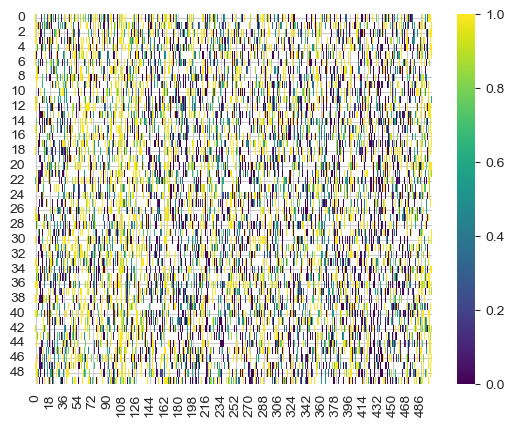

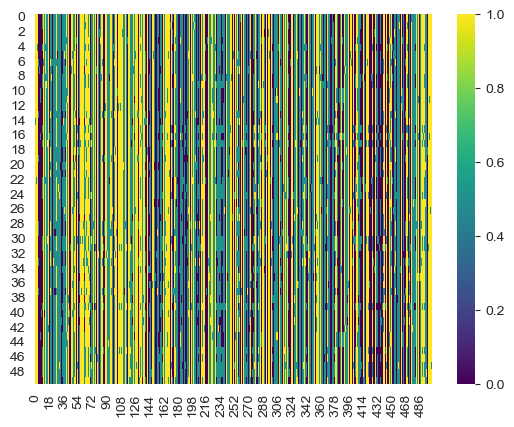

In [132]:
sns.heatmap(vaf, cmap='viridis')
plt.show()

sns.heatmap(genotype_gt, cmap='viridis')
plt.show()

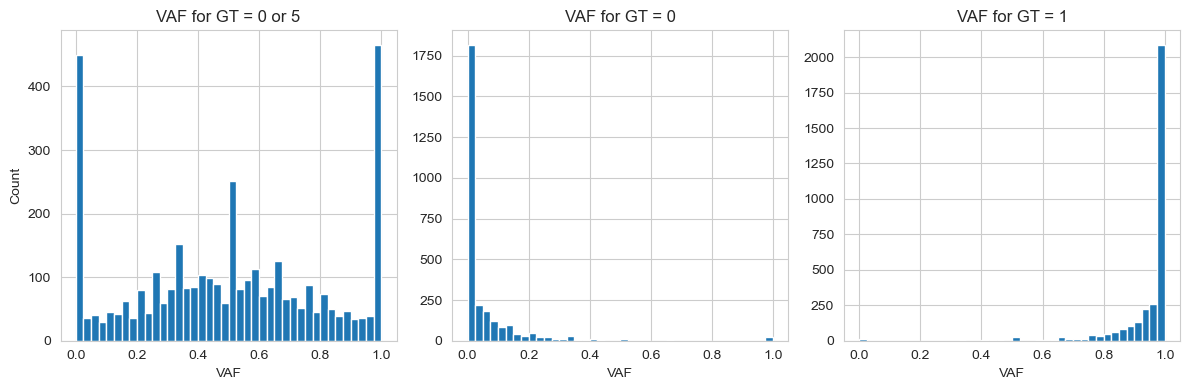

In [133]:
vaf_gt_0_5 = vaf[genotype_gt == 0.5]
vaf_gt_0 = vaf[genotype_gt == 0]
vaf_gt_1 = vaf[genotype_gt == 1]

plt.figure(figsize=(12, 4))

# 1) Combined (0 and 5)
plt.subplot(1, 3, 1)
plt.hist(vaf_gt_0_5, bins=40)
plt.title("VAF for GT = 0 or 5")
plt.xlabel("VAF")
plt.ylabel("Count")

# 2) GT = 0
plt.subplot(1, 3, 2)
plt.hist(vaf_gt_0, bins=40)
plt.title("VAF for GT = 0")
plt.xlabel("VAF")

# 3) GT = 1
plt.subplot(1, 3, 3)
plt.hist(vaf_gt_1, bins=40)
plt.title("VAF for GT = 1")
plt.xlabel("VAF")

plt.tight_layout()
plt.show()

In [190]:
c1 = []
c2 = []
for i in range(10):
    base_path = rf"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data\50c500m_param_testing\homoplasy_fraction_0"
    genotype_gt1 = np.loadtxt(fr"{base_path}\mut_indicator\mut_indicator_{i}.txt", dtype=str)
    # genotype_gt1 = vectorized_map(genotype_gt1)

    base_path = rf"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data\50c500m_param_testing\homoplasy_fraction_0_5"
    genotype_gt2 = np.loadtxt(fr"{base_path}\mut_indicator\mut_indicator_{i}.txt", dtype=str)
    # genotype_gt2 = vectorized_map(genotype_gt2)

    count1 = np.unique(genotype_gt1, return_counts=True)[1]
    count2 = np.unique(genotype_gt2, return_counts=True)[1]

    c1.append(count1[1])
    c2.append(count2[1])

In [191]:
print(np.mean(c1), np.mean(c2))

2746.4 3032.9


In [186]:
path = r"C:\Users\Norio\Documents\GitHub\SCITE-RNA-v2\data\simulated_data\50c500m_param_testing\CNV_fraction_0_3"
genotype = np.loadtxt(fr"{path}\genotype\genotype_0.txt", dtype=str)
alt_alleles = np.loadtxt(fr"{path}\genotype\alt_alleles_0.txt", dtype=int)
ref_alleles = np.loadtxt(fr"{path}\genotype\ref_alleles_0.txt", dtype=int)

alt = np.loadtxt(fr"{path}\alt\alt_0.txt")
ref = np.loadtxt(fr"{path}\ref\ref_0.txt")
cov = alt + ref
vaf = np.divide(alt, cov)

C:\Users\Norio\AppData\Local\Temp\ipykernel_25124\2749552540.py:9: RuntimeWarning: invalid value encountered in divide
  vaf = np.divide(alt, cov)


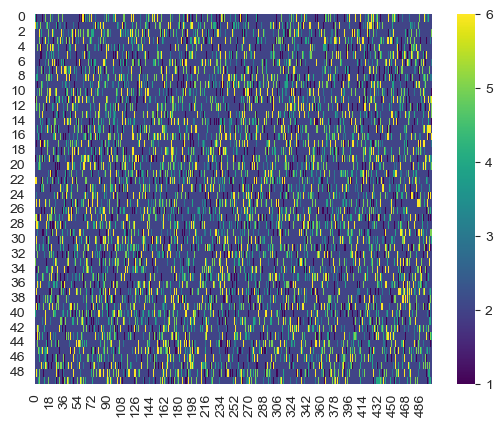

In [187]:
sns.heatmap(alt_alleles+ref_alleles, cmap='viridis')
plt.show()

In [188]:
cna = alt_alleles/(alt_alleles+ref_alleles)
vals, counts = np.unique(cna, return_counts=True)

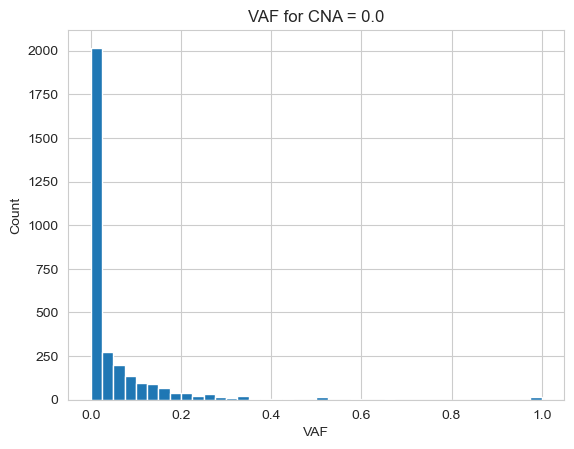

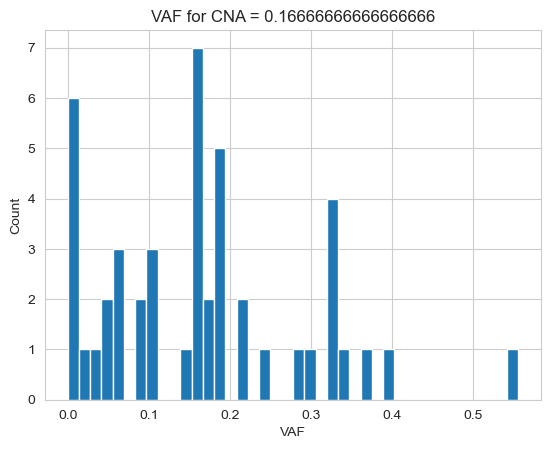

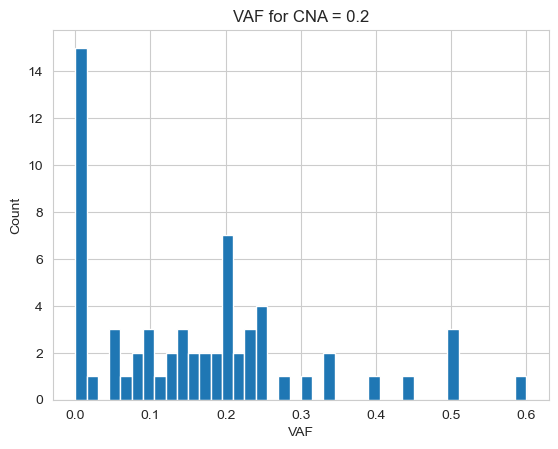

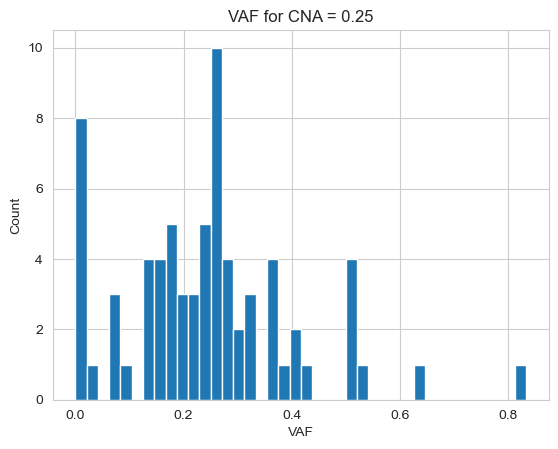

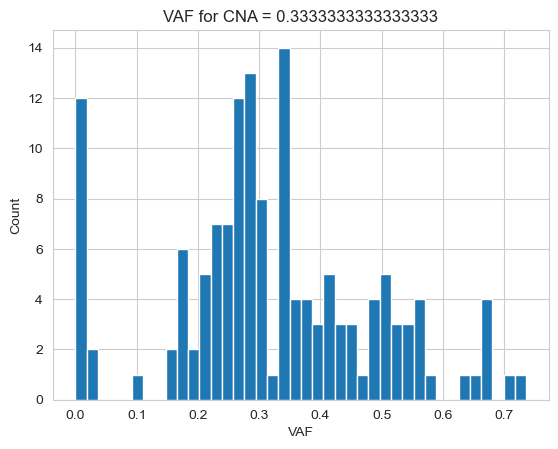

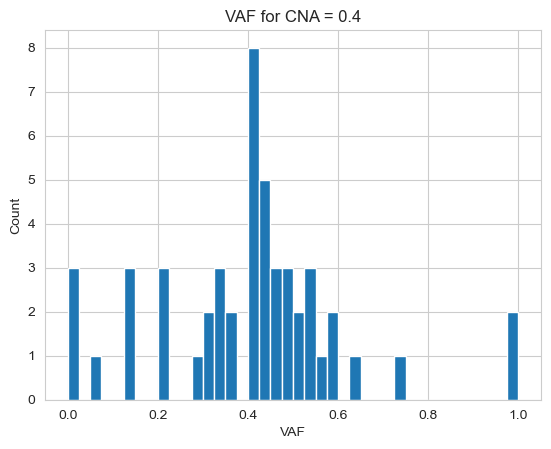

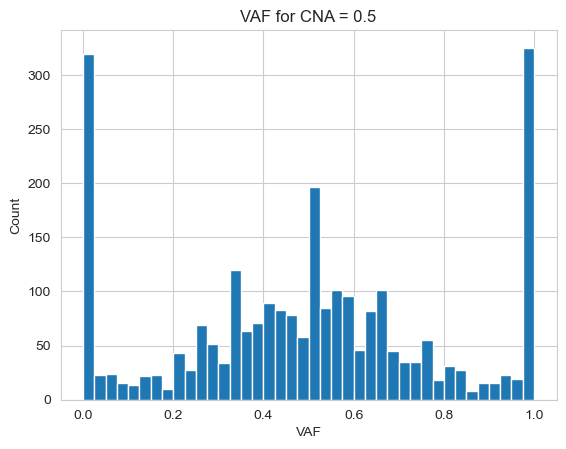

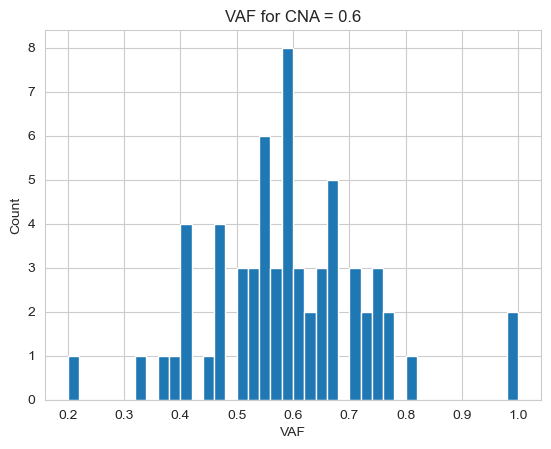

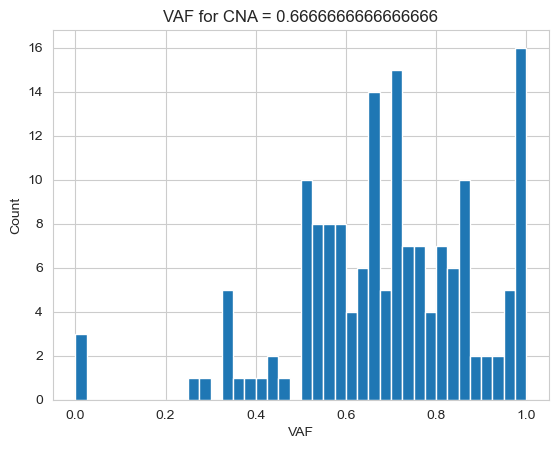

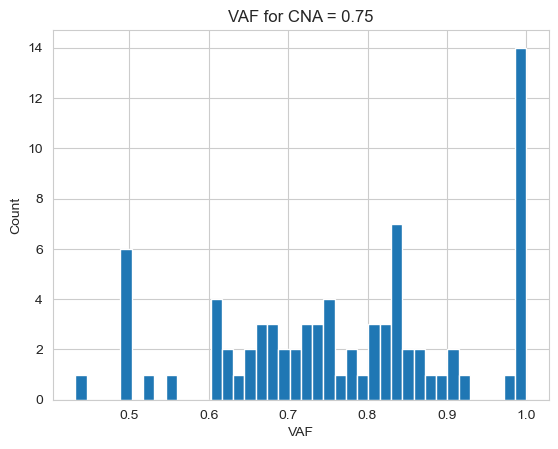

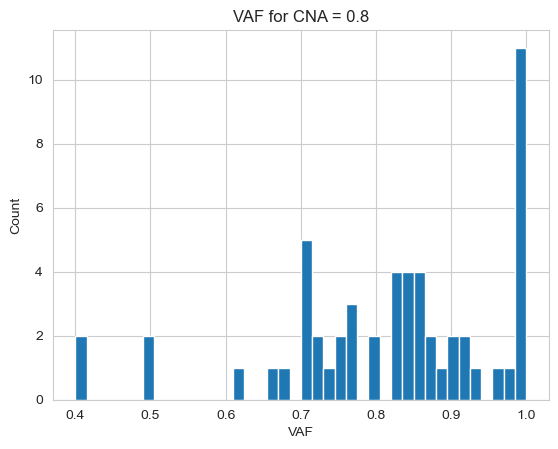

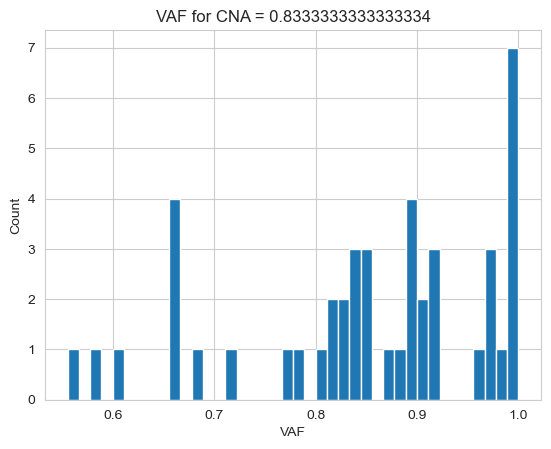

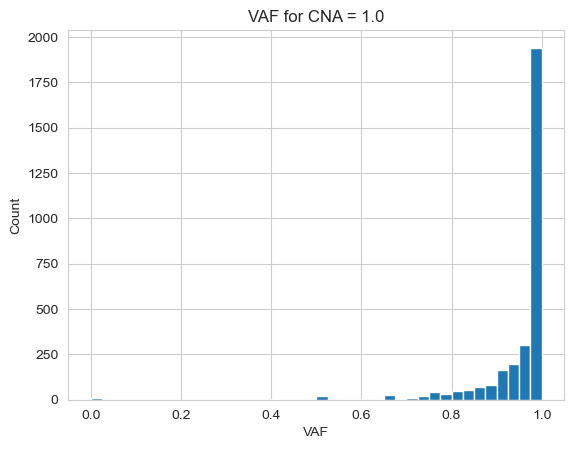

In [189]:
for v in vals:
    vaf_g = vaf[cna == v]

    plt.hist(vaf_g, bins=40)
    plt.title(f"VAF for CNA = {v}")
    plt.xlabel("VAF")
    plt.ylabel("Count")
    plt.show()

C:\Users\Norio\AppData\Local\Temp\ipykernel_25124\840692321.py:28: UserWarning: Glyph 8712 (\N{ELEMENT OF}) missing from current font.
  plt.tight_layout()
C:\Users\Norio\anaconda3\envs\RNA\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8712 (\N{ELEMENT OF}) missing from current font.
  func(*args, **kwargs)
C:\Users\Norio\anaconda3\envs\RNA\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8712 (\N{ELEMENT OF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


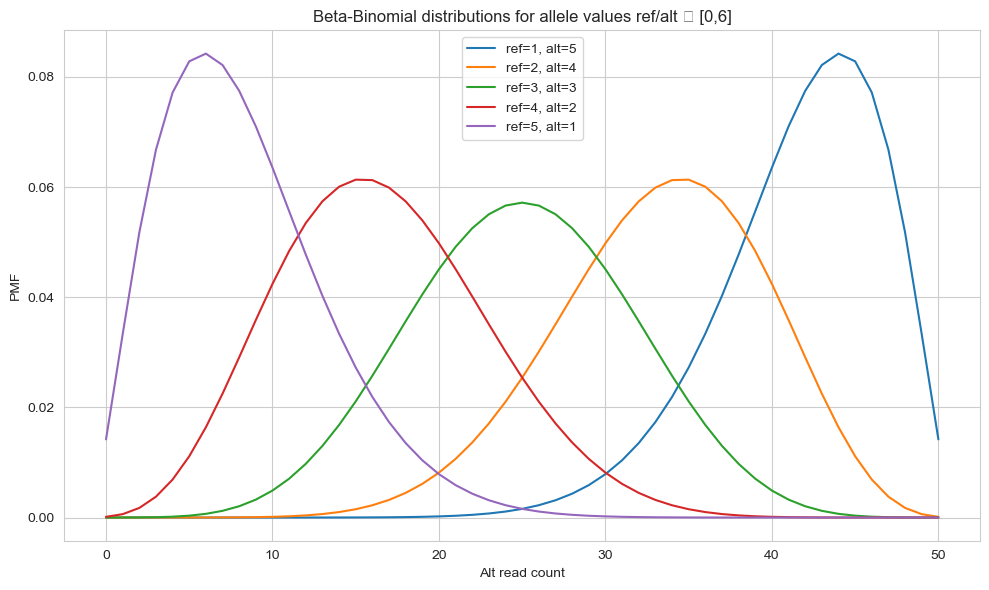

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import betabinom

# Example assumptions (adjust to real values if provided later):
total = 6
ref = np.arange(1, total)
alt = total - ref

overdispersion_h = 6
coverage = 50

alpha = (alt / (ref + alt + 1e-9)) * overdispersion_h * (ref+alt)/2
beta = overdispersion_h * (ref+alt)/2 - alpha

k = np.arange(0, coverage+1)
pmfs = []
for a, b in zip(alpha, beta):
    pmfs.append(betabinom.pmf(k, coverage, a, b))

plt.figure(figsize=(10,6))
for idx, r in enumerate(ref):
    plt.plot(k, pmfs[idx], label=f"ref={r}, alt={alt[idx]}")
plt.xlabel("Alt read count")
plt.ylabel("PMF")
plt.title("Beta-Binomial distributions for allele values ref/alt ∈ [0,6]")
plt.legend()
plt.tight_layout()
